In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'gtsrb-german-traffic-sign:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F82373%2F191501%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240404%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240404T072947Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D31fb8895fa59f083dc3791125815eb2e7e9d0dcfb0e1521188b74d818d16ec8012abab8073c5f0e1dcd659e0eb99280804b32af28e9dc5f818282d98b5ed0c1f1e53844915e0391d3c6fca7d2e66a2d03524d04b691bd424c81c7cb1beb8c2e5ccebe50238ca2e1024e23d979e610716f9d20d3bdb6db2bcfb33588d40b19cb35e26fa2f3fc03a7aa94220f5e8a88db46412274e67d05d9bc76924d149d585ff51cf03048f418448d9468534ec94fc6f79cbafb37e6b8eeae0412902349bbbe66eed5f3d80a0e0610eda405e08e1aa2b35bcd3d52d1d794d6747b09a3ee98b7cffb01e0d16e60e1715378e49240a6644ed42666234f5188641c5b2512df7d6cf'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 641568792 bytes downloaded
Downloaded and uncompressed: gtsrb-german-traffic-sign
Data source import complete.


# German Traffic Sign Classification:
### https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
Simple approach to classifying german traffic signs only using the sklearn capabilities.
the images are converted to gray scale before training the model.
Various methods were studied to extract the dominant image colour and add these information to the gray scale. However, this didn't lead to any improvement and is left out from this notebook.

Data exploration was conducted seperately and several classifier were studied.

This notebook is the result of a final project of a ML course. It's more of an educational value to showcase classical sklearn methods.

Better pre-processing, e.g. proper improvement of the brightness and correcting the angle of view of the traffic signs, should improve the score a lot. Some classes are under-represented. Scores could be improved by changing this.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', None)
from glob import glob
import time
from IPython.display import display

import cv2
from cv2 import imread
from cv2 import resize as Resize

from sklearn.cluster import MiniBatchKMeans

from sklearn.model_selection import train_test_split
from sklearn import metrics as metrics
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
!pip install Augmentor
import Augmentor
np.random.seed(42)

### ML functions

In [ ]:
def myTimer(func):
    def wrapper(*args, **kwargs):
        t   = time.time()
        ret = func(*args, **kwargs)
        print('computation time = %s s' % (time.time() - t))
        return(ret)
    return(wrapper)

@myTimer
def doML(alg, settings, XTrain, YTrain, XTest, YTest, title=None):
    if title:
        print('====   %s   ====' % title)
    else:
        print('===========================================================================')
    print(alg)
    print(settings)
    myAlg = alg(**settings)
    myAlg.fit(XTrain, YTrain)
    YPred = myAlg.predict(XTest)
    print(metrics.classification_report(YTest, YPred))
    print('===========================================================================')
    return(myAlg)

@myTimer
def doCV(alg, grid, X, Y, title=None):
    if title:
        print('%s' % title)
    else:
        print('===========================================================================')

    myGS = GridSearchCV(alg(), grid)
    myGS.fit(X, Y)

    res = pd.DataFrame(myGS.cv_results_)
    display(res)
    return(myGS)

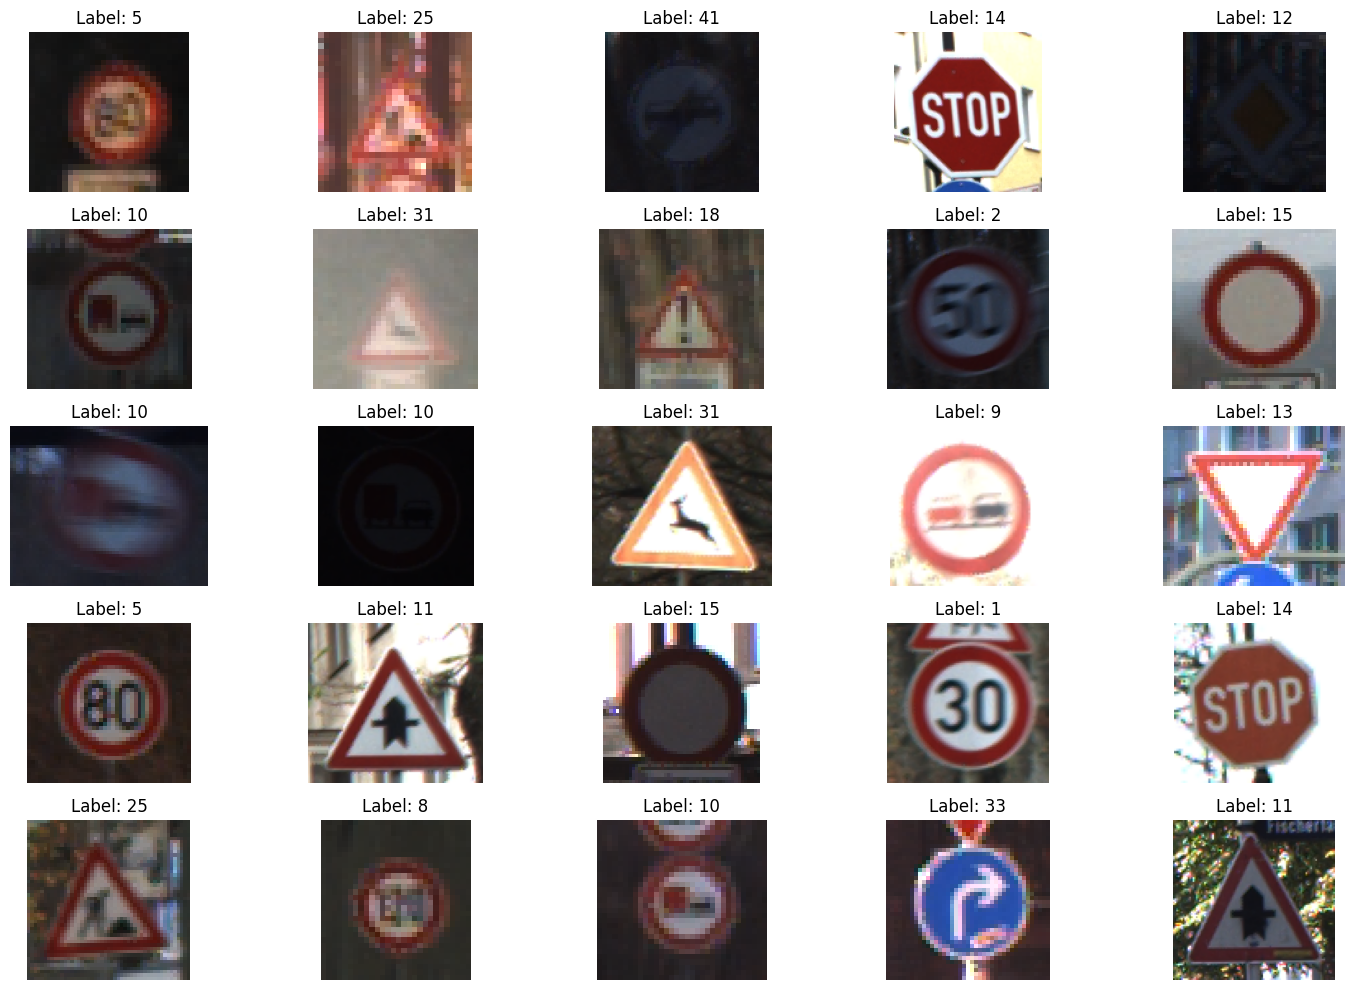

In [ ]:
import matplotlib.pyplot as plt
import random

data = pd.read_csv('../input/gtsrb-german-traffic-sign/Train.csv')

random_indices = random.sample(range(len(data)), 25)
random_images = data.iloc[random_indices]

plt.figure(figsize=(15, 10))
for i, (_, row) in enumerate(random_images.iterrows()):
    image_path = '../input/gtsrb-german-traffic-sign/' + row['Path']
    image_label = row['ClassId']
    image = plt.imread(image_path)

    plt.subplot(5, 5, i + 1)
    plt.imshow(image)
    plt.title(f"Label: {image_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Pre-Processing Pipeline
    read single row of pandas dataFrame and load image
    increase brightness
    apply region of interest
    scales according to nuShape
    returns gray scale/colour image

In [ ]:
def increase_brightness(img, value=60):

    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2RGB)
    return img

def add_noise(img, mean=0, sigma=1):

    noisy_img = np.clip(img + np.random.normal(mean, sigma, img.shape), 0, 255).astype(np.uint8)
    return noisy_img

def transformIMG(pandasRow, newShape=(50, 50), color=False):
    img = cv2.imread('../input/gtsrb-german-traffic-sign/' + pandasRow['Path'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    imgBright = increase_brightness(img, value=60)

    imgNoisy = add_noise(imgBright, sigma=0.2)

    angle = np.random.randint(-1, 1)
    rows, cols, _ = imgNoisy.shape
    rotation_matrix = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    imgRotated = cv2.warpAffine(imgNoisy, rotation_matrix, (cols, rows))

    zoom_factor = np.random.uniform(0.95, 1.05)
    imgZoomed = cv2.resize(imgRotated, None, fx=zoom_factor, fy=zoom_factor)

    imgTrafo = cv2.resize(imgZoomed, newShape, interpolation=cv2.INTER_LINEAR)
    imgGray = cv2.cvtColor(imgTrafo.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    return imgTrafo if color else imgGray

def prepData(pdDataFrame, nuShape, col=False):
    '''
    load all images, call pre-processing
    return table of flattened images and labels
    '''
    X, Y = [], []
    x, y = np.ogrid[ 0:nuShape[0], 0:nuShape[0] ]
    x, y = x - int(.5*nuShape[0]), y - int(.5*nuShape[0])
    if col:
        for k in range(pdDataFrame.shape[0]):
            d = pdDataFrame.iloc[k]
            img = transformIMG(d, newShape=nuShape, color=col)
            X.append(img[x**2 + y**2 <= .25*nuShape[0]**2,:])
            Y.append( d['ClassId'] )
    else:
        for k in range(pdDataFrame.shape[0]):
            d = pdDataFrame.iloc[k]
            img = transformIMG(d, newShape=nuShape)
            X.append(img[x**2 + y**2 <= .25*nuShape[0]**2])
            Y.append( d['ClassId'] )
    return(np.asarray(X), np.asarray(Y))

### Load full data set

In [ ]:
data = pd.read_csv('../input/gtsrb-german-traffic-sign/Train.csv')
nuShape = (20,20)
X, Y = prepData(data, nuShape)

### reduce amount of data using PCA

In [ ]:
myPCA = PCA(n_components=100)
XPCA = myPCA.fit_transform(X)

In [ ]:
XFTrain, XFTest, YFTrain, YFTest = train_test_split(XPCA, Y, test_size=.2, random_state=42)#

### quick check of random forest and MLP: computation time and first scores with default settings

In [ ]:
settingsRFC = {'n_jobs' : 8}
o = doML(RandomForestClassifier, settingsRFC, XFTrain, YFTrain, XFTest, YFTest, title='Random Forest Classifier')

====   Random Forest Classifier   ====
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
{'n_jobs': 8}
              precision    recall  f1-score   support

           0       1.00      0.41      0.58        44
           1       0.76      0.90      0.82       474
           2       0.79      0.86      0.82       452
           3       0.82      0.74      0.78       295
           4       0.82      0.84      0.83       420
           5       0.69      0.82      0.75       332
           6       0.92      0.94      0.93        82
           7       0.84      0.79      0.82       276
           8       0.88      0.84      0.86       283
           9       0.98      0.92      0.95       304
          10       0.92      0.94      0.93       349
          11       0.81      0.96      0.88       242
          12       0.88      0.95      0.92       454
          13       0.98      0.99      0.99       441
          14       0.97      0.93      0.95       167
          15       0.99 

In [ ]:
settingsMLP = {}
o = doML(MLPClassifier, settingsMLP, XFTrain, YFTrain, XFTest, YFTest, title=None)

<class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
{}
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        44
           1       0.95      0.93      0.94       474
           2       0.91      0.94      0.92       452
           3       0.92      0.88      0.90       295
           4       0.92      0.96      0.94       420
           5       0.88      0.86      0.87       332
           6       1.00      1.00      1.00        82
           7       0.93      0.89      0.91       276
           8       0.89      0.88      0.89       283
           9       0.96      0.98      0.97       304
          10       0.98      0.97      0.97       349
          11       0.94      0.97      0.95       242
          12       0.96      0.96      0.96       454
          13       0.98      0.99      0.98       441
          14       1.00      0.98      0.99       167
          15       0.98      0.91      0.94       127
        

### Best RFC after Grid Search

In [ ]:
gridRFC = {'n_estimators' : 220, 'max_depth' : None, 'min_samples_split' : 10, \
           'max_features' : 'sqrt', 'max_leaf_nodes' : None, 'min_impurity_decrease' : 0.0, \
           'bootstrap' : False, 'oob_score' : False, 'class_weight' : 'balanced', \
           'ccp_alpha' : 0.0, 'max_samples' : None}
bestRFC = doML(RandomForestClassifier, gridRFC, XFTrain, YFTrain, XFTest, YFTest, title='BRF')

====   BRF   ====
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
{'n_estimators': 220, 'max_depth': None, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'bootstrap': False, 'oob_score': False, 'class_weight': 'balanced', 'ccp_alpha': 0.0, 'max_samples': None}
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        44
           1       0.86      0.90      0.88       474
           2       0.89      0.86      0.87       452
           3       0.83      0.78      0.80       295
           4       0.89      0.87      0.88       420
           5       0.76      0.81      0.78       332
           6       0.92      0.96      0.94        82
           7       0.87      0.84      0.85       276
           8       0.90      0.88      0.89       283
           9       0.99      0.96      0.97       304
          10       0.95      0.97      0.96       349
          11       0.87 

In [ ]:
gridRFC = {'n_estimators' : [220], 'max_depth' : [None], 'min_samples_split' : [10], \
           'max_features' : ['sqrt'], 'max_leaf_nodes' : [None], 'min_impurity_decrease' : [0.0], \
           'bootstrap' : [False], 'oob_score' : [False], 'class_weight' : ['balanced'], \
           'ccp_alpha' : [0.0], 'max_samples' : [None]}
o = doCV(RandomForestClassifier, gridRFC, XPCA, Y, title='best RFC')

best RFC


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_ccp_alpha,param_class_weight,param_max_depth,param_max_features,param_max_leaf_nodes,param_max_samples,param_min_impurity_decrease,param_min_samples_split,param_n_estimators,param_oob_score,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,280.527952,6.017532,0.913622,0.04186,False,0.0,balanced,None,sqrt,None,None,0.0,10,220,False,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.673553,0.717292,0.682734,0.682734,0.723632,0.695989,0.02036,1


computation time = 1765.4994378089905 s


### best MLP after Grid Search

In [ ]:
gridMLP = {'hidden_layer_sizes' : [(510)], 'activation' : ['relu'], 'max_iter' : [2000], \
          'solver' : ['adam'], 'batch_size' : [100], 'learning_rate' : ['constant']}
o = doCV(MLPClassifier, gridMLP, XPCA, Y, title='MLP')

MLP


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_batch_size,param_hidden_layer_sizes,param_learning_rate,param_max_iter,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,220.197274,49.356,0.101453,0.012568,relu,100,510,constant,2000,adam,"{'activation': 'relu', 'batch_size': 100, 'hid...",0.794313,0.844682,0.84532,0.815608,0.846321,0.829249,0.02095,1


computation time = 1268.2616157531738 s


In [ ]:
settingsMLP = {'hidden_layer_sizes' : (510), 'activation' : 'relu', 'max_iter' : 2000, \
          'solver' : 'adam', 'batch_size' : 100, 'learning_rate' : 'constant'}
bestMLP = doML(MLPClassifier, settingsMLP, XFTrain, YFTrain, XFTest, YFTest, title='best')

====   best   ====
<class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
{'hidden_layer_sizes': 510, 'activation': 'relu', 'max_iter': 2000, 'solver': 'adam', 'batch_size': 100, 'learning_rate': 'constant'}
              precision    recall  f1-score   support

           0       0.91      0.98      0.95        44
           1       0.97      0.94      0.95       474
           2       0.90      0.97      0.93       452
           3       0.94      0.93      0.93       295
           4       0.97      0.91      0.94       420
           5       0.91      0.88      0.89       332
           6       1.00      0.99      0.99        82
           7       0.91      0.92      0.92       276
           8       0.94      0.94      0.94       283
           9       0.99      0.97      0.98       304
          10       0.98      0.96      0.97       349
          11       0.95      0.98      0.97       242
          12       0.96      0.98      0.97       454
          13       0

## Test Data

In [ ]:
Testdata = pd.read_csv('../input/gtsrb-german-traffic-sign/Test.csv')
nuShape = (20,20)
XTest, YTest = prepData(data, nuShape)

In [ ]:
XTestPCA = myPCA.transform(XTest)

### Classify test data using MLP

In [ ]:
YRealPred = bestMLP.predict(XTestPCA)
print(metrics.classification_report(YTest, YRealPred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       210
           1       0.98      0.98      0.98      2220
           2       0.96      0.99      0.97      2250
           3       0.96      0.98      0.97      1410
           4       0.99      0.96      0.97      1980
           5       0.97      0.95      0.96      1860
           6       1.00      0.99      0.99       420
           7       0.95      0.97      0.96      1440
           8       0.97      0.95      0.96      1410
           9       0.99      0.99      0.99      1470
          10       1.00      0.98      0.99      2010
          11       0.98      0.99      0.99      1320
          12       0.98      1.00      0.99      2100
          13       1.00      1.00      1.00      2160
          14       1.00      1.00      1.00       780
          15       0.99      0.99      0.99       630
          16       1.00      1.00      1.00       420
          17       1.00    

### Classify test data using RFC

In [ ]:
YRealPred2 = bestRFC.predict(XTestPCA)
print(metrics.classification_report(YTest, YRealPred2))

              precision    recall  f1-score   support

           0       0.99      0.94      0.97       210
           1       0.97      0.97      0.97      2220
           2       0.98      0.97      0.97      2250
           3       0.96      0.95      0.96      1410
           4       0.97      0.97      0.97      1980
           5       0.95      0.96      0.96      1860
           6       0.99      0.99      0.99       420
           7       0.97      0.97      0.97      1440
           8       0.97      0.97      0.97      1410
           9       1.00      0.99      0.99      1470
          10       1.00      1.00      1.00      2010
          11       0.97      0.99      0.98      1320
          12       0.98      0.99      0.99      2100
          13       1.00      1.00      1.00      2160
          14       0.99      0.99      0.99       780
          15       0.99      0.98      0.99       630
          16       1.00      1.00      1.00       420
          17       1.00    

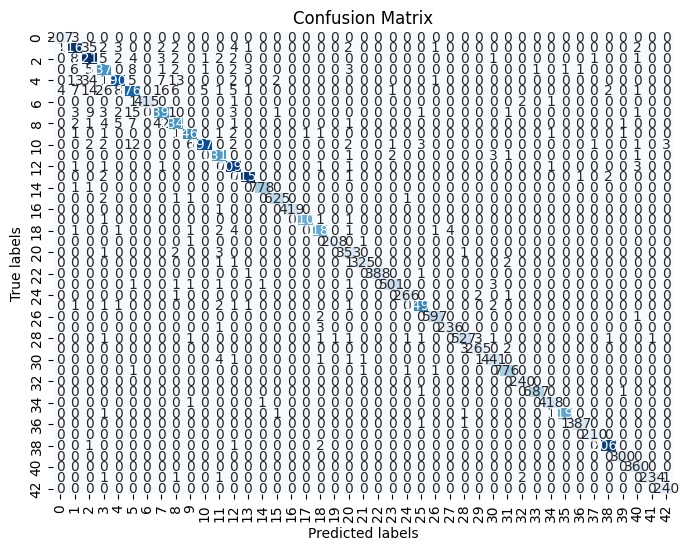

In [ ]:

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(YTest, YRealPred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

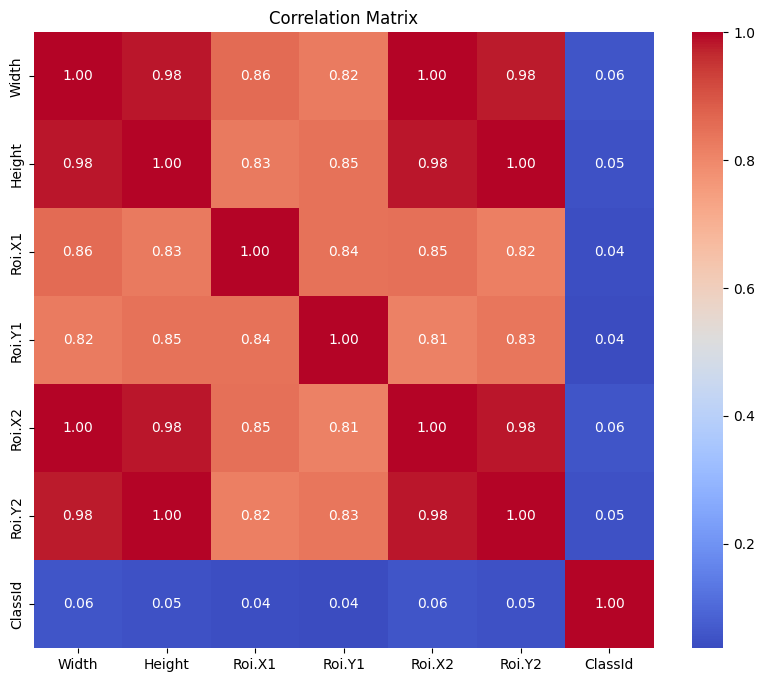

In [ ]:
import seaborn as sns
numeric_data = data.select_dtypes(include=[np.number])

correlation_matrix = numeric_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

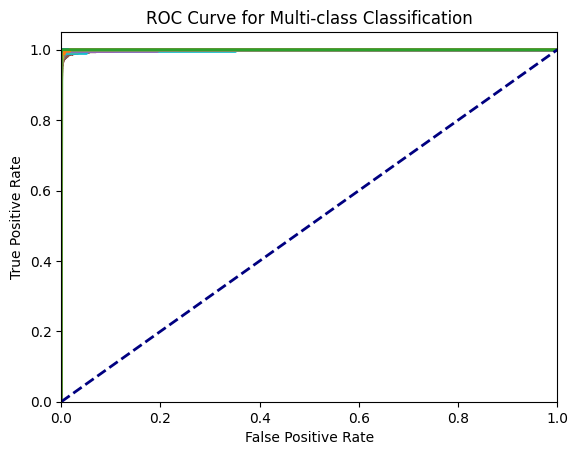

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

YTest_binarized = label_binarize(YTest, classes=np.unique(YTest))
n_classes = YTest_binarized.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(YTest_binarized[:, i], YRealPred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_micro, tpr_micro, _ = roc_curve(YTest_binarized.ravel(), YRealPred_proba.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification')
plt.show()

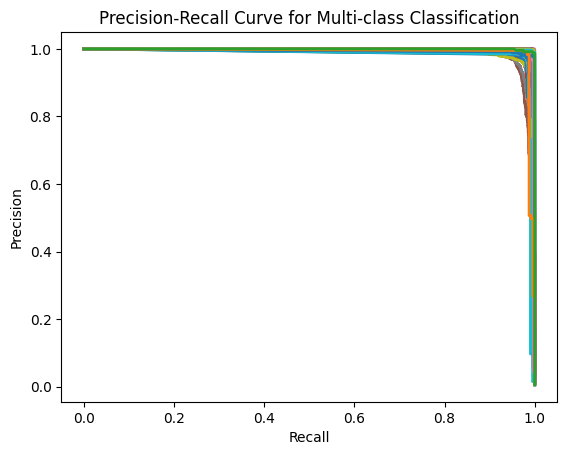

In [ ]:
from sklearn.metrics import precision_recall_curve

precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(YTest_binarized[:, i], YRealPred_proba[:, i])

plt.figure()
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multi-class Classification')
plt.show()

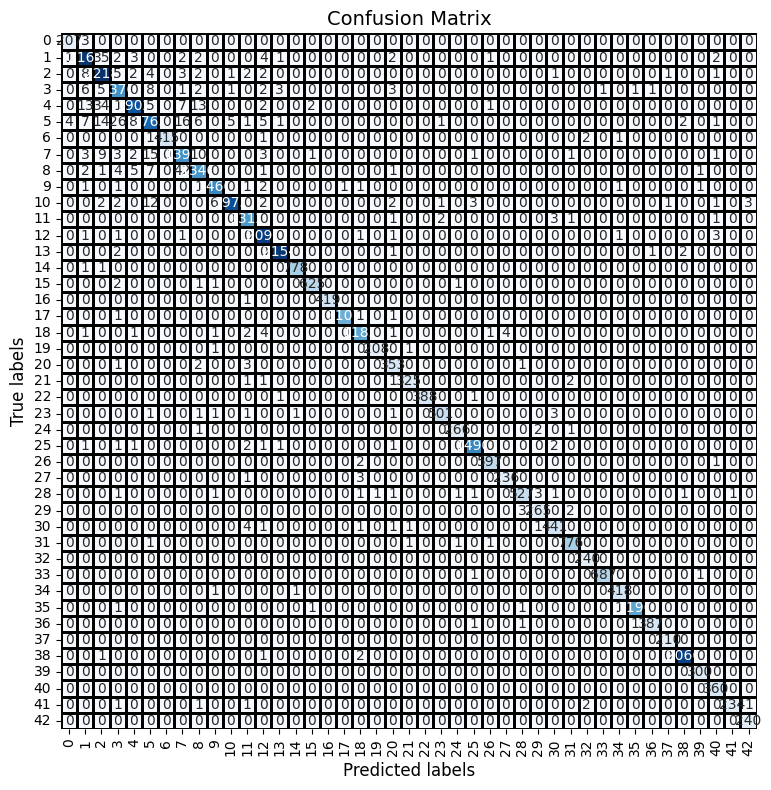

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(YTest, YRealPred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False,
            linewidths=2, linecolor='black', square=True)
plt.xlabel('Predicted labels', fontsize=12)
plt.ylabel('True labels', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.tight_layout()
plt.show()
